In [1]:
from picamera_darthvader_detection_AIY import *

In [8]:
import time

import picamera
import numpy as np

In [10]:
frameWidth = 256 
frameHeight = 256
frameRate = 20
contrast = 40
rotation = 180

In [11]:
model = ModelDescriptor(
    name="DarthVaderDetector",
    input_shape=(1, frameWidth, frameHeight, 3),
    input_normalizer=(128.0, 128.0),
    compute_graph=utils.load_compute_graph(os.path.join(os.getcwd(), "darthvader.binaryproto")))

In [12]:
ANCHORS = np.genfromtxt("/opt/aiy/models/mobilenet_ssd_256res_0.125_person_cat_dog_anchors.txt")

In [13]:
# This cell needs to be executed only once
inference = ImageInference(model)

In [7]:
# %%time # will show how long a cell takes to execute

# https://picamera.readthedocs.io/en/release-1.13/recipes2.html
with picamera.PiCamera() as camera:
    camera.resolution = (frameWidth, frameHeight)
    camera.framerate = frameRate
    camera.rotation = 180 # CogniFly's camera is upside down
    time.sleep(2)
    output = np.empty((frameWidth, frameHeight, 3), dtype=np.uint8)
    camera.capture(output, 'rgb')

In [15]:
output = Image.fromarray(output)

In [16]:
image_center, offset = crop_center(output)
result = inference.run(image_center)

In [18]:
# The weird shapes used for concat and concat_1 are just copying the output tensors
# shapes when using the model directly from tensorflow.
# => #classes: number of classes during training (the number used in the config file)
concat = np.asarray(result.tensors['concat'].data).reshape((1, 1278, 1, 4)) #(1, 1278*#classes, 1, 4)
concat_1 = np.asarray(result.tensors['concat_1'].data).reshape((1, 1278, 2)) #(1, 1278, #classes + 1)

detection_boxes, detection_scores, detection_classes = process_output_tensor(concat, 
                                                                             concat_1, 
                                                                             ANCHORS, 
                                                                             classes=[1], 
                                                                             IoU_thres=0.5, 
                                                                             raw_boxes=False, 
                                                                             score_threshold=0.3)

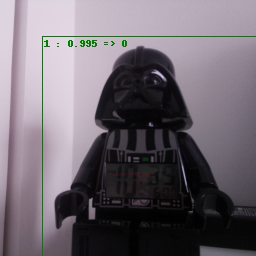

In [19]:
display(draw_boxes_raw(output.copy(), detection_boxes[1], detection_scores[1], 1, threshold=0.0))

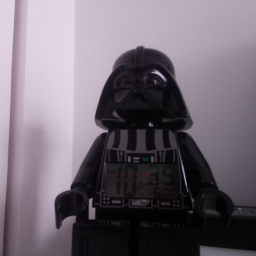

In [20]:
display(output)